In [1]:
import sys
sys.path.append("/homes/gf332/compression-without-quantization/code")
sys.path.append("/homes/gf332/compression-without-quantization/code/thesis_code")


import os, glob
from tqdm import tqdm as tqdm

import tensorflow.compat.v1 as tf
import tensorflow_compression as tfc
import tensorflow_probability as tfp
import tensorflow.contrib.eager as tfe
tfd = tfp.distributions
tfk = tf.keras
tfl = tf.keras.layers
tfq = tf.quantization

from binary_io import to_bit_string, from_bit_string

from pln import ProbabilisticLadderNetwork
from vae import VariationalAutoEncoder

from miracle import create_dataset, quantize_image, read_png

from misc import stateless_normal_sample

from greedy_compression import code_greedy_sample
from coded_greedy_sampler import code_grouped_greedy_sample, decode_grouped_greedy_sample
#from coded_importance_sampler import code_grouped_importance_sample, decode_grouped_importance_sample

import matplotlib.pyplot as plt
import numpy as np

#tf.enable_eager_execution()

/scratch/gf332/compression_venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/gf332/compression_venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/gf332/compression_venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/gf332/compression_venv/lib/python3.5/site-pack

In [2]:
dist_dir = "/scratch/gf332/data/kodak_cwoq/"

q2_loc = np.load(dist_dir + "pln_q2_loc.npy").flatten()[:10]
q2_scale = np.load(dist_dir + "pln_q2_scale.npy").flatten()[:10]

p2_loc = np.load(dist_dir + "pln_p2_loc.npy").flatten()[:10]
p2_scale = np.load(dist_dir + "pln_p2_scale.npy").flatten()[:10]

q1_loc = np.load(dist_dir + "pln_q1_loc.npy").flatten()
q1_scale = np.load(dist_dir + "pln_q1_scale.npy").flatten()

p1_loc = np.load(dist_dir + "pln_p1_loc.npy").flatten()
p1_scale = np.load(dist_dir + "pln_p1_scale.npy").flatten()

In [4]:
def code_greedy_sample(t_loc, 
                        t_scale,
                        p_loc,
                        p_scale,
                        n_bits_per_step, 
                        n_steps, 
                        seed, 
                        rho=1.):
    
    n_samples = int(2**n_bits_per_step)

    # The scale divisor needs to be square rooted because
    # we are dealing with standard deviations and not variances
    scale_divisor = np.sqrt(n_steps)
    
    proposal_shard = tfd.Normal(loc=p_loc / n_steps,
                                scale=rho * p_scale / scale_divisor)
    
    target = tfd.Normal(loc=t_loc,
                        scale=t_scale)

    # Setup greedy sampler for loop
    def loop_step(i, sample_index, best_sample):
        samples = stateless_normal_sample(loc=proposal_shard.loc, 
                                          scale=proposal_shard.scale, 
                                          num_samples=n_samples, 
                                          seed=1000 * seed + i)
        
        test_samples = tf.tile(tf.expand_dims(best_sample, 0), [n_samples, 1]) + samples

        log_probs = tf.reduce_sum(target.log_prob(test_samples), axis=1)

        index = tf.argmax(log_probs)

        best_sample = test_samples[index, :]

        return [i + 1, tf.concat((sample_index, [index]), axis=0), best_sample]
    
    i = tf.constant(0)
    best_sample = tf.zeros(tf.shape(p_loc), dtype=tf.float32)
    sample_index = tf.cast([], tf.int32)
    
    cond = lambda i, sample_index, best_sample: i < n_steps

    _, sample_index, best_sample = tf.while_loop(cond=cond,
                                   body=loop_step, 
                                   loop_vars=[i, sample_index, best_sample],
                                   shape_invariants=[i.get_shape(), 
                                                     tf.TensorShape([None]), 
                                                     best_sample.get_shape()])
    
    
    sample_index = tf.map_fn(lambda x: tf.numpy_function(to_bit_string, [x, n_bits_per_step], tf.string), 
                             sample_index,
                             dtype=tf.string)
    
    sample_index = tf.numpy_function(lambda indices: ''.join([ind.decode('utf-8') for ind in indices]),
                                     [sample_index],
                                     tf.string)
    
    return best_sample, sample_index

In [5]:
n_bits_per_step = 14
n_steps = 30
seed = 42
rho = 1.
first_level_max_group_size_bits=12
second_level_max_group_size_bits=4

q2 = tfd.Normal(loc=q2_loc, scale=q2_scale)
q1 = tfd.Normal(loc=q1_loc, scale=q1_scale)

p1 = tfd.Normal(loc=p1_loc, scale=p1_scale)

with tf.Session() as sess:
    
#     res = code_importance_sample(t_loc=q2_loc,
#                                 t_scale=q2_scale,
#                                 p_loc=p2_loc,
#                                 p_scale=p2_scale,
#                                 n_coding_bits=20,
#                                 seed=1)
    
#     bs, si = sess.run(res)
    
#     avg_imp_samp_ll = tf.reduce_mean(q2.log_prob(bs))
    
#     aisl = sess.run(avg_imp_samp_ll)
#     asl = sess.run(tf.reduce_mean(q2.log_prob(q2.sample())))
    
#     print("Average importance sample likelihood: {:.4f}".format(aisl))
#     print("Average  sample likelihood: {:.4f}".format(asl))
#     res = code_greedy_sample(t_loc=q1_loc,
#                               t_scale=q1_scale,
#                               p_loc=p1_loc,
#                               p_scale=p1_scale,
#                               n_bits_per_step=n_bits_per_step, 
#                               n_steps=n_steps, 
#                               seed=seed, 
#                               rho=1.)
    
#     bs, si = sess.run(res)
    
#     qs = q1.sample()
    
#     avg_imp_samp_ll = tf.reduce_mean(q1.log_prob(bs))
    
#     aisl = sess.run(avg_imp_samp_ll)
#     asl, qs = sess.run([tf.reduce_mean(q1.log_prob(qs)), qs])
    
#     print("Average importance sample likelihood: {:.4f}".format(aisl))
#     print("Average  sample likelihood: {:.4f}".format(asl))
    
#     res = decode_greedy_sample_(sample_index=si, 
#                                   p_loc=p1_loc,
#                                   p_scale=p1_scale,
#                                   n_bits_per_step=14, 
#                                   n_steps=30, 
#                                   seed=seed, 
#                                   rho=1.)
#     samp = sess.run(res)

    res = code_grouped_greedy_sample(sess=sess,
                                    target=q1, 
                                   proposal=p1,
                                   n_steps=n_steps, 
                                   n_bits_per_step=n_bits_per_step,
                                   seed=seed,
                                   max_group_size_bits=12,
                                   adaptive=True,
                                   backfitting_steps=0,
                                   use_log_prob=False,
                                   rho=1.)
    
    sample, bitcode, group_start_indices = res
    
    bs = sample
    
    qs = q1.sample()
    
    avg_imp_samp_ll = tf.reduce_mean(q1.log_prob(bs))
    
    aisl = sess.run(avg_imp_samp_ll)
    asl, qs = sess.run([tf.reduce_mean(q1.log_prob(qs)), qs])
    
    print("Average importance sample likelihood: {:.4f}".format(aisl))
    print("Average  sample likelihood: {:.4f}".format(asl))
    
#     dec = decode_grouped_greedy_sample_(sess=sess,
#                                   bitcode=bitcode, 
#                                  group_start_indices=group_start_indices,
#                                  proposal=p1, 
#                                  n_bits_per_step=n_bits_per_step, 
#                                  n_steps=n_steps, 
#                                  seed=seed,
#                                  adaptive=True,
#                                  rho=1.)

Total KL to split up: 36215.69 bits, maximum bits per group: 420, estimated number of groups: 87.0,coding 98304 dimensions


100%|██████████| 88/88 [00:26<00:00,  3.35it/s]

Average importance sample likelihood: 0.4434
Average  sample likelihood: 0.4943


In [13]:
q1 = tfd.Normal(loc=q1_loc,
                scale=q1_scale)
p1 = tfd.Normal(loc=p1_loc,
                scale=p1_scale)

bs, si = code_greedy_sample(target=q1, 
                           proposal=p1, 
                           n_bits_per_step=14, 
                           n_steps=50, 
                           seed=1)

bs = tf.reshape(bs, [-1])
qs = q1.sample()
aisl = tf.reduce_mean(q1.log_prob(bs))
asl = tf.reduce_mean(q1.log_prob(qs))
print("Average importance sample likelihood: {:.4f}".format(aisl))
print("Average  sample likelihood: {:.4f}".format(asl))

Average importance sample likelihood: -0.5841
Average  sample likelihood: 0.8912


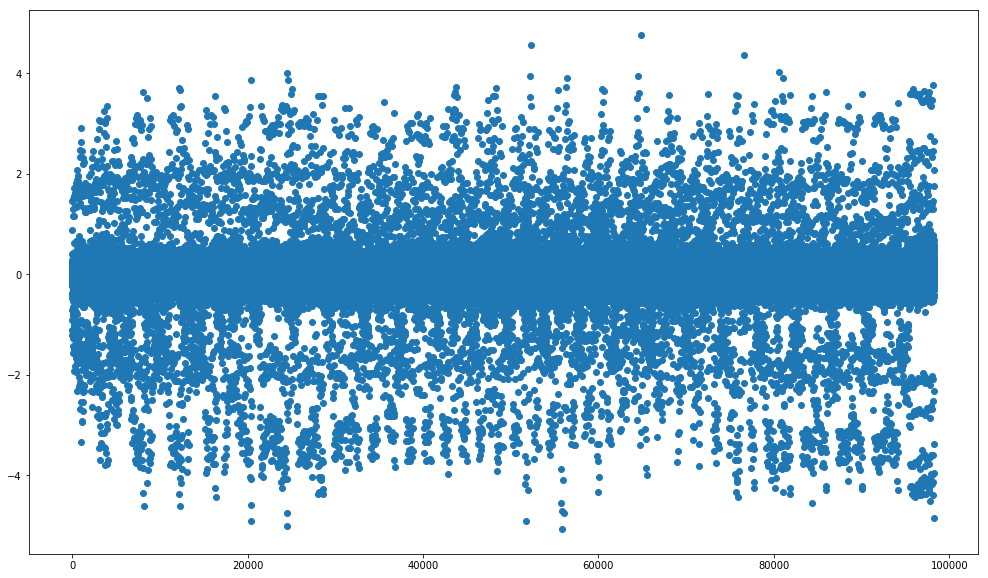

In [10]:
plt.figure(figsize=(17, 10))

plt.scatter(range(len(bs)), bs)
#plt.scatter(range(len(qs)), qs, alpha=0.3)